In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [2]:
## 1. Implement ε-Greedy and UCB

In [3]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [4]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms = narms
        self.epsilon = epsilon
        self.Q0 = Q0
        self.pullsNum = np.zeros(narms)
        self.values = np.full(narms, Q0)
        
    def play(self, tround, context=None):
        # tround not used in this implementation of MAB
        rand = np.random.random()
        # if rand < epsilon, pick random arm (explore), otherwise pick best arm (exploit) (with random tiebreak)
        if rand < self.epsilon:
            return np.random.randint(self.narms)
        else:
            maxValue = max(self.values)
            bestArms = [i for i, value in enumerate(self.values) if value == maxValue]
            return np.random.choice(bestArms)
        
    def update(self, arm, reward, context=None):
        if self.values[arm] == self.Q0:
            self.values[arm] = reward
        else:
            value = (self.values[arm] * self.pullsNum[arm] + reward) / (self.pullsNum[arm] + 1)
            self.values[arm] = value
        self.pullsNum[arm] += 1
    

In [5]:
class BernoulliArm:
    def __init__(self):
        self.p = np.random.random()
    
    def pull(self):
        return int(np.random.random() < self.p)

In [6]:
bernoulliArms = [BernoulliArm() for i in range(10)]
[a.p for a in bernoulliArms]

[0.024720759901472822,
 0.992402994515029,
 0.07314369305962387,
 0.014176883428488884,
 0.7831487936728914,
 0.4550515167074527,
 0.6790586426195484,
 0.6260793137619918,
 0.8546199225486811,
 0.5842458967422974]

In [7]:
epsGreedy = EpsGreedy(10, 0.1)
accumulated_rewards = 0
pulls_num = 0
running_avg_rewards = [0] * 2000
# print(epsGreedy.values)
for i in range(0, 2000):
    arm = epsGreedy.play(None)
    reward = bernoulliArms[arm].pull()
    accumulated_rewards += reward
    epsGreedy.update(arm, reward)
    
    pulls_num += 1
    running_avg_rewards[i] = accumulated_rewards / pulls_num
    
#     if (i % 100 == 0):
#         print("-")
#         print(accumulated_rewards)
#         print(epsGreedy.values)
#         print("-")

print("accumulated_rewards " + str(accumulated_rewards))
# print(epsGreedy.values)
print("max reward possible " + str(max([b.p for b in bernoulliArms])*2000))
print("regret " + str(max([b.p for b in bernoulliArms]) * 2000 - accumulated_rewards))

accumulated_rewards 1889
max reward possible 1984.805989030058
regret 95.80598903005807


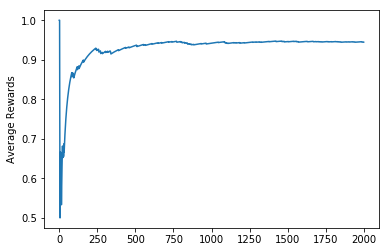

In [8]:
plt.plot(running_avg_rewards)
plt.ylabel("Average Rewards")
plt.show()

In [9]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho
        self.Q0 = Q0
        self.pullsNum = np.zeros(narms)
        self.values = np.full(narms, Q0)
    
    def play(self, tround, context=None):
        # compute the sum of average reward and confidence interval for each arm
        estimatedValues = [0] * self.narms
        for i in range(self.narms):
            avg_arm_value = self.values[i]
            if avg_arm_value == self.Q0:
                estimatedValues[i] = self.Q0
            else:
                confidence_interval = np.sqrt((self.rho * np.log(tround)) / self.pullsNum[i])
                estimatedValues[i] = avg_arm_value + confidence_interval
        
        # choose randomly between arms with max sum of avg reward and confidence interval
        maxValue = max(estimatedValues)
        bestArms = [i for i, value in enumerate(estimatedValues) if value == maxValue]
        return np.random.choice(bestArms)
        
    def update(self, arm, reward, context=None):
        if self.values[arm] == self.Q0:
            self.values[arm] = reward
        else:
            value = (self.values[arm] * self.pullsNum[arm] + reward) / (self.pullsNum[arm] + 1)
            self.values[arm] = value
        self.pullsNum[arm] += 1
        
    

In [10]:
bernoulliArms = [BernoulliArm() for i in range(10)]
[a.p for a in bernoulliArms]

[0.23798591010405146,
 0.9676724672609208,
 0.9922745092488273,
 0.2587785147848032,
 0.1503146620760335,
 0.7787391640752427,
 0.1911878096149665,
 0.7602783662788827,
 0.009288577294310318,
 0.32449256348675337]

In [11]:
mab = UCB(10, 2)
accumulated_rewards = 0
# print(epsGreedy.values)
for i in range(0, 2000):
    arm = mab.play(i)
    reward = bernoulliArms[arm].pull()
    accumulated_rewards += reward
    mab.update(arm, reward)

#     if (i % 100 == 0):
#         print("-")
#         print(accumulated_rewards)
#         print(epsGreedy.values)
#         print("-")

print("accumulated_rewards " + str(accumulated_rewards))
print(mab.values)
maxReward = max([b.p for b in bernoulliArms])*2000
print("max reward possible " + str(maxReward))
print("regret " + str(maxReward - accumulated_rewards))

#[a.p for a in bernoulliArms]

accumulated_rewards 1829
[0.34615385 0.96788321 0.99405352 0.07142857 0.16666667 0.74782609
 0.07142857 0.67532468 0.07142857 0.35714286]
max reward possible 1984.5490184976547
regret 155.54901849765474


## 2. Off-Policy Evaluation

In [17]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    round_rewards = []
    stream_iterator = 0
    
    if nrounds == None:
        return round_rewards
    
    for t in range(nrounds):
        while True:
            if stream_iterator >= len(arms):
                print(stream_iterator)
                return round_rewards
            if mab.play(t) == int(arms[stream_iterator]) - 1: # -1 because the arms from data is one indexed
                break
            else:
                stream_iterator += 1
        
        round_rewards.append(rewards[stream_iterator])
        mab.update(int(arms[stream_iterator]) - 1, rewards[stream_iterator], contexts[stream_iterator])
        stream_iterator += 1
    
    #print(stream_iterator)
    return round_rewards
    

In [13]:
data = np.loadtxt("dataset.txt")
arms = data[:,0]
rewards = data[:,1]
contexts = data[:,2:]

In [68]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))
print(mab.pullsNum)
print(mab.values)

EpsGreedy average reward 0.23
[ 12. 523. 174.   5.   6.   5.   6.   4.  61.   4.]
[0.         0.28871893 0.14367816 0.         0.         0.
 0.         0.         0.13114754 0.        ]


In [63]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.16375


array([0.        , 0.25615764, 0.14285714, 0.025     , 0.07692308,
       0.08928571, 0.22307692, 0.        , 0.21212121, 0.025     ])

## 3. Contextual Bandits

In [16]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        
        
    def play(self, tround, context):
        
    
    def update(self, arm, reward, context):
        
    

IndentationError: expected an indented block (<ipython-input-16-0c2e2d1f0e69>, line 20)

In [ ]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

## 4. Evaluation
### 4.A.

### 4.B.

## 5. KernelUCB

In [ ]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [ ]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        
    
    def play(self, tround, context):
        
    
    def update(self, arm, reward, context):
        
    